In [22]:
# this script is to develop the visual outputs for our final paper
# Create new charts folder
# folder will have example video 
# extract video and audio into memory (example file should be short)
# run pratt analysis on audio
# normalize values
# predict using saved model
# chart original, robustl2s, and our prediction

In [23]:
#package installs
#E:\Python310\python.exe -m pip install --upgrade pip
#!E:\Python310\python.exe -m pip install git+https://github.com/openai/whisper.git soundfile
!E:\Python310\Scripts\pip3.exe install ffmpeg av
#!E:\Python310\python.exe -m pip uninstall torch torchvision torchaudio -y
!E:\Python310\python.exe -m pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


Looking in indexes: https://download.pytorch.org/whl/cu121


In [38]:
#Global variables
import socket
import os
ENV_HOSTNAME = socket.gethostname()
print('ENV_HOSTNAME:' + ENV_HOSTNAME)

#store defaults for Jacob here:
ENV_FOLDER_DATA = 'C:\\Users\\jakes\\Documents\\COMS 4732 - Computer Vision\\W4732CompVisFinal\\Data\\'
ENV_FOLDER_DATA_PROC = 'C:\\Users\\jakes\\Documents\\COMS 4732 - Computer Vision\\W4732CompVisFinal\\Data_Proc\\'
ENV_PRATT = ''


if ENV_HOSTNAME == 'JWGamingPC':
    ENV_FOLDER_DATA = 'E:\\W4732 Computer Vision\\Final Paper Data\\'
    ENV_FOLDER_DATA_PROC = 'E:\\W4732 Computer Vision\\Final Paper Data Proc\\'
    ENV_PRATT = ''

print('ENV_FOLDER_DATA:' + ENV_FOLDER_DATA)
print('ENV_PRATT:' + ENV_PRATT)

# Create folder structure
import os
os.makedirs(ENV_FOLDER_DATA_PROC + 'segmentation', exist_ok=True)
os.makedirs(ENV_FOLDER_DATA_PROC + 'targetdf', exist_ok=True)
os.makedirs(ENV_FOLDER_DATA_PROC + 'pratt', exist_ok=True)
os.makedirs(ENV_FOLDER_DATA_PROC + 'eps', exist_ok=True)
os.makedirs(ENV_FOLDER_DATA_PROC + 'clips', exist_ok=True)
os.makedirs(ENV_FOLDER_DATA_PROC + 'charts', exist_ok=True)


ENV_HOSTNAME:JWGamingPC
ENV_FOLDER_DATA:E:\W4732 Computer Vision\Final Paper Data\
ENV_PRATT:


In [39]:
#define variables for the process
#
# p / i / s / j / h
ANALYSIS_TYPE = 'p'
PATH_ORIGMP4 = ''
PATH_ROBMP4 = ''

PATH_MODEL = ''
if ANALYSIS_TYPE == 'p':
    PATH_MODEL = ENV_FOLDER_DATA_PROC + 'charts\\' + 'pitchVidNetV3.pt'


In [26]:
import parselmouth
from parselmouth.praat import call
import moviepy
from moviepy.editor import *
import moviepy.editor
from pydub import AudioSegment
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
import torch
import torchvision

#for this particular
def create_chart_data(fileseg_mp4):

    #save all the data into this dictionary
    dict_results = {}

    #filepaths
    folderpath_base = ENV_FOLDER_DATA_PROC + 'charts\\'
    filepath_mp4 = folderpath_base + fileseg_mp4
    filepath_mp3 = folderpath_base + 'temp.mp3'
    filepath_wav = folderpath_base + 'temp.wav'
    filepath_normmp4 = folderpath_base + 'temp.mp4'
    filepath_clip = folderpath_base + 'tempclip.mp4'

    #convert mp4 to mp3
    video_clip = moviepy.editor.VideoFileClip(filepath_mp4)
    audio_clip = video_clip.audio
    audio_clip.write_audiofile(filepath_mp3)
    audio_clip.close()
    video_clip.close()

    #extract wav from mp3
    mp3_clip = AudioSegment.from_mp3(filepath_mp3)
    mp3_clip.export(filepath_wav, format="wav")

    #load wav file for pratt analysis
    sound_total = parselmouth.Sound(filepath_wav)

    #get pratt values
    list_pitch = []
    list_intensity = []
    list_shimmer = []
    list_jitter = []
    list_harmonics = []

    for t in range(40):

        start_time = t * 0.1
        end_time = (t + 1) * 0.1
        sound = sound_total.extract_part(from_time=start_time, to_time=end_time)

        #iterate through the parts of the sound

        pointprocess = call(sound, "To PointProcess (periodic, cc)",75, 600)
        #dict_temp['pointprocess'] = pointprocess
        
        #https://parselmouth.readthedocs.io/_/downloads/en/stable/pdf/
        #gets the pitch , and sets the pitch floor to 75 and tge outcg max to 600
        try:
            pitch = call(sound, "To Pitch", 0.0, 75, 600)
            val_pitch = call(pitch, "Get mean", 0, 0,"Hertz")
        except:
            val_pitch = None
        
        ##-	For intensity extraction, set the pitch floor to 100Hz. Use ‘energy’ averaging method to get mean intensity.
        try:
            intensity = call(sound, "To Intensity", 100,0.01)
            val_intensity = call(intensity, "Get mean", 0, 0,"energy")
        except:
            val_intensity = None

        ##Shimmer
        # For shimmer, extract local shimmer only, and set period floor to 0.0001s, period ceiling to 0.02s, maximum period factor to 1.3, and maximum amplitude factor to 1.6.
        try:
            val_shimmer = call([sound, pointprocess], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
        except:
            val_shimmer = None
        
        # For jitter, extract local jitter only, and set period floor to 0.0001s, period ceiling to 0.02s, and maximum period factor to 1.3
        #Please convert from a Sound object to a PointProcess (periodic, cc) object. (#74)
        #https://github.com/drfeinberg/PraatScripts/blob/master/Measure%20Pitch%2C%20HNR%2C%20Jitter%2C%20Shimmer%2C%20and%20Formants.ipynb
        #f0min , f0max
        try:
            val_jitter = call(pointprocess, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3)
        except:
            val_jitter = None
        
        #-	To calculate HNR (harmonics-to-noise ratio), extract harmonicity (cc) first. Set time step to 0.01, minimum pitch to 75Hz, silence threshold to 0.1, and number of periods per window to 1.0.
        try:
            harmonics = call(sound, "To Harmonicity (cc)", 0.01, 75, 0.1, 1.0)
            val_harmonics = call(harmonics, "Get mean", 0, 0)
        except:
            val_harmonics = None

        #add to relevant lists
        list_pitch.append(val_pitch)
        list_intensity.append(val_intensity)
        list_shimmer.append(val_shimmer)
        list_jitter.append(val_jitter)
        list_harmonics.append(val_harmonics)
    
    dict_results['p'] = list_pitch
    dict_results['i'] = list_intensity
    dict_results['s'] = list_shimmer
    dict_results['j'] = list_jitter
    dict_results['h'] = list_harmonics

    #extract target video data
    clip_total = VideoFileClip(filepath_mp4).without_audio().resize(height=360)
    clip_total = moviepy.video.fx.all.crop(clip_total,x_center=320, y_center=180,
                    width=640, height=360)
    clip_total = clip_total.fx(vfx.blackwhite)
    clip_total.write_videofile(filepath_normmp4, fps=10)
    #get subclip
    ffmpeg_extract_subclip(filepath_normmp4, 0, 4, targetname=filepath_clip)

    

    torchvision.set_video_backend('pyav')
    reader = torchvision.io.VideoReader(filepath_clip, "video")
    reader.set_current_stream("video")
    transform = torchvision.transforms.Grayscale()

    video_frames = torch.empty(0)
    frames = [] 
    ct = 1
    for frame in reader:
        tempframe = transform(frame['data'])
        frames.append(tempframe)
        ct += 1
    for x in range(40):
        frames.append( torch.empty((1,360,640), dtype=torch.int8) )
    if len(frames) > 0:
        video_frames = torch.stack(frames[:40], 0)
    
    dict_results['v'] = video_frames
    
    return dict_results





In [40]:
#create model result
PATH_MODEL = ENV_FOLDER_DATA_PROC + 'charts\\' + 'pitchVidNetV3.pt'

import torch.nn as nn
import torch.nn.functional as F


class VideoConvNet(nn.Module):
    def __init__(self, in_channels=1, num_classes=41):
        super().__init__()
        # TODO: Initialize network layers
        
        self.layer1 = nn.Sequential(
            nn.Conv3d(in_channels=in_channels, out_channels=8, kernel_size=6, padding=3, stride=3),
            nn.BatchNorm3d(8),
            nn.LeakyReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv3d(in_channels=8, out_channels=32, kernel_size=5, padding=3, stride=3),
            nn.BatchNorm3d(32),
            nn.LeakyReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv3d(in_channels=32, out_channels=64, kernel_size=4, padding=3, stride=2),
            nn.BatchNorm3d(64),
            nn.LeakyReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2))
        # self.layer4 = nn.Sequential(
        #     nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
        #     nn.BatchNorm2d(128),
        #     nn.LeakyReLU(),
        #     nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc1 = nn.Sequential(
            nn.Linear(960, 256),
            nn.LeakyReLU(),
            nn.Dropout(0.5))
        self.fc2 = nn.Sequential(
            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.Dropout(0.5))
        self.fc3 = nn.Sequential(
            nn.Linear(128, num_classes))

    def forward(self, x):
        # TODO: Implement the forward pass with using the layers defined above
        #       and the proper activation functions
        #print("input: ", x.shape)
        x = self.layer1(x)
        #print("layer1: ", x.shape)
        x = self.layer2(x)
        #print("layer2: ", x.shape) 
        x = self.layer3(x)
        #print("layer3: ", x.shape)
        #x = self.layer4(x)
        #print("layer4: ", x.shape)
        x = x.view(x.size(0), -1)
        #print("flatten: ", x.shape)
        x = self.fc1(x)
        #print("fc1: ", x.shape)
        x = self.fc2(x)
        #print("fc2: ", x.shape)
        x = self.fc3(x)
        #print("fc3: ", x.shape)
        return x






In [41]:

import torch
import torch.nn.functional as F


class JWVideoConvNet(torch.nn.Module):
    def __init__(self, in_channels=1, num_classes=41):
        super().__init__()
        # TODO: Initialize network layers
        
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv3d(in_channels=in_channels, out_channels=4, kernel_size=15, padding=3, stride=5),
            #torch.nn.BatchNorm3d(8),
            torch.nn.Sigmoid(),
            #torch.nn.MaxPool3d(kernel_size=2, stride=2)
            )
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv3d(in_channels=4, out_channels=8, kernel_size=8, padding=1, stride=2),
            #torch.nn.BatchNorm3d(16),
            torch.nn.Sigmoid(),
            #torch.nn.MaxPool3d(kernel_size=2, stride=2)
            )
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv3d(in_channels=8, out_channels=16, kernel_size=3, padding=1, stride=1),
            #torch.nn.BatchNorm3d(32),
            torch.nn.Sigmoid(),
            #torch.nn.MaxPool3d(kernel_size=2, stride=2)
            )
        # self.layer4 = nn.Sequential(
        #     nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
        #     nn.BatchNorm2d(128),
        #     nn.LeakyReLU(),
        #     nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc1 = torch.nn.Sequential(
            torch.nn.Linear(32208, 4096),
            torch.nn.Sigmoid(),
            torch.nn.Dropout(0.1))
        self.fc2 = torch.nn.Sequential(
            torch.nn.Linear(4096, 1024),
            torch.nn.Sigmoid(),
            torch.nn.Dropout(0.1))
        self.fc3 = torch.nn.Sequential(
            torch.nn.Linear(1024, num_classes))

    def forward(self, x):
        # TODO: Implement the forward pass with using the layers defined above
        #       and the proper activation functions
        #print("input: ", x.shape)
        x = self.layer1(x)
        #print("layer1: ", x.shape)
        x = self.layer2(x)
        #print("layer2: ", x.shape) 
        x = self.layer3(x)
        #print("layer3: ", x.shape)
        #x = self.layer4(x)
        #print("layer4: ", x.shape)
        x = x.view(x.size(0), -1)
        #print("flatten: ", x.shape)
        x = self.fc1(x)
        #print("fc1: ", x.shape)
        x = self.fc2(x)
        #print("fc2: ", x.shape)
        x = self.fc3(x)
        #print("fc3: ", x.shape)
        return x



For paper, want to showcase 2 things:
1) performance on RobustL2M speaker data
2) performance on dataset data

<H1> Pitch </H1>

MoviePy - Writing audio in E:\W4732 Computer Vision\Final Paper Data Proc\charts\temp.mp3


MoviePy - Done.


Moviepy - Building video E:\W4732 Computer Vision\Final Paper Data Proc\charts\temp.mp4.
Moviepy - Writing video E:\W4732 Computer Vision\Final Paper Data Proc\charts\temp.mp4



Moviepy - Done !
Moviepy - video ready E:\W4732 Computer Vision\Final Paper Data Proc\charts\temp.mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
MoviePy - Writing audio in E:\W4732 Computer Vision\Final Paper Data Proc\charts\temp.mp3


MoviePy - Done.


Moviepy - Building video E:\W4732 Computer Vision\Final Paper Data Proc\charts\temp.mp4.
Moviepy - Writing video E:\W4732 Computer Vision\Final Paper Data Proc\charts\temp.mp4



Moviepy - Done !
Moviepy - video ready E:\W4732 Computer Vision\Final Paper Data Proc\charts\temp.mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
torch.Size([1, 1, 40, 360, 640])
142.35284423828125
111.59185527230966
97.93546874773604


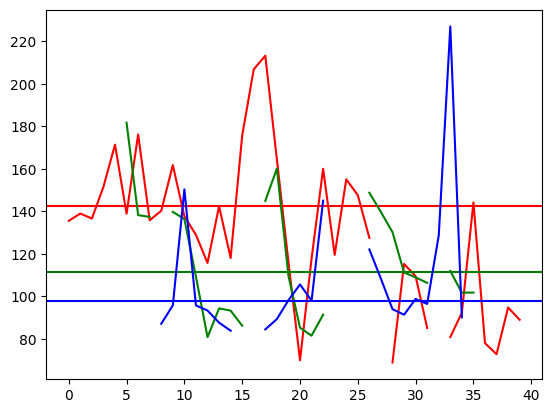

In [29]:
#robustL2M improvements
#get the data for the original file
orig_path =  'original.mp4'
#use the model to create a target median + 40 data
dict_orig = create_chart_data(orig_path)

#get the data for the robustls2
robu_path = 'robustl2s.mp4'
dict_robu = create_chart_data(robu_path)


#pitch_model = VideoConvNet()
#pitch_model.load_state_dict(torch.load(ENV_FOLDER_DATA_PROC + 'charts\\' + 'pitchVidNetV4.pt'))


pitch_model = JWVideoConvNet()
pitch_model.load_state_dict(torch.load(ENV_FOLDER_DATA_PROC + 'charts\\' + 'JWPitchModv02.pt'))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pitch_model.to(device=device)
import torch
torch.manual_seed(60) #20
x = dict_orig['v'].to(device).to(torch.float).movedim(0,1).unsqueeze(0) / 255.0
print(x.size())
pitch_model_predictions = pitch_model(x)


#chart data
import numpy as np
prediction_line_val = (pitch_model_predictions.to('cpu').detach() * 600)[0][0].item()
prediction_data_pts = np.array((pitch_model_predictions.to('cpu').detach() * 600)[0][1:].tolist())
prediction_data_pts[prediction_data_pts > 280] = np.NaN
prediction_data_pts[prediction_data_pts < 60] = np.NaN
#zero out anything under 80 hz and over 280 hz
print(prediction_line_val)
#print(prediction_data_pts)

original_line_val = np.nanmedian(list(filter(None, dict_orig['p']) ))
original_data_pts = np.array(dict_orig['p'])
original_data_pts[original_data_pts > 280] = np.NaN
original_data_pts[original_data_pts < 60] = np.NaN
print(original_line_val)
#print(original_data_pts)

robu_line_val = np.nanmedian(list(filter(None, dict_robu['p']) ))
robu_data_pts = np.array(dict_robu['p'])
robu_data_pts[robu_data_pts > 280] = np.NaN
robu_data_pts[robu_data_pts < 60] = np.NaN
print(robu_line_val)
#print(robu_data_pts)


import matplotlib.pyplot as plt
plt.axhline(y=prediction_line_val, color='r', linestyle='-')
plt.plot(list(range(40)), prediction_data_pts, color = 'r')
plt.axhline(y=original_line_val, color='g', linestyle='-')
plt.plot(list(range(40)), original_data_pts, color = 'g')
plt.axhline(y=robu_line_val, color='b', linestyle='-')
plt.plot(list(range(40)), robu_data_pts, color = 'b')
plt.show()

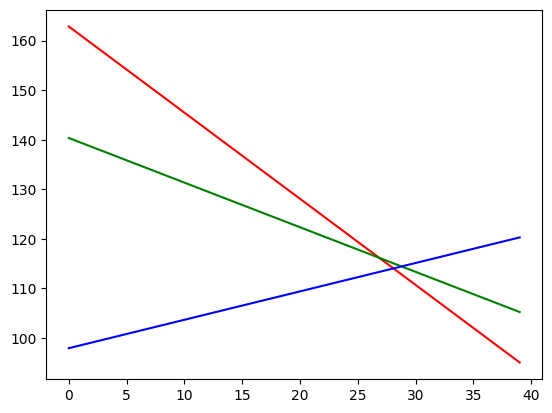

In [30]:
#this looks good
import matplotlib.pyplot as plt
idx = np.isfinite(prediction_data_pts)
pred_m, pred_b = np.polyfit(np.array(list(range(40)))[idx], prediction_data_pts[idx], 1)
plt.plot(list(range(40)), pred_m*np.array(list(range(40))) + pred_b, color = 'r')

idx = np.isfinite(original_data_pts)
orig_m, orig_b = np.polyfit(np.array(list(range(40)))[idx], original_data_pts[idx], 1)
plt.plot(list(range(40)), orig_m*np.array(list(range(40))) + orig_b, color = 'g')

idx = np.isfinite(robu_data_pts)
robu_m, robu_b = np.polyfit(np.array(list(range(40)))[idx], robu_data_pts[idx], 1)
plt.plot(list(range(40)), robu_m*np.array(list(range(40))) + robu_b, color = 'b')
plt.show()

In [ ]:
# summary statistic for all of the data

<H1> Intensity </H1>

MoviePy - Writing audio in E:\W4732 Computer Vision\Final Paper Data Proc\charts\temp.mp3


MoviePy - Done.


Moviepy - Building video E:\W4732 Computer Vision\Final Paper Data Proc\charts\temp.mp4.
Moviepy - Writing video E:\W4732 Computer Vision\Final Paper Data Proc\charts\temp.mp4



Moviepy - Done !
Moviepy - video ready E:\W4732 Computer Vision\Final Paper Data Proc\charts\temp.mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
MoviePy - Writing audio in E:\W4732 Computer Vision\Final Paper Data Proc\charts\temp.mp3


MoviePy - Done.


Moviepy - Building video E:\W4732 Computer Vision\Final Paper Data Proc\charts\temp.mp4.
Moviepy - Writing video E:\W4732 Computer Vision\Final Paper Data Proc\charts\temp.mp4



Moviepy - Done !
Moviepy - video ready E:\W4732 Computer Vision\Final Paper Data Proc\charts\temp.mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
-55.762786865234375
62.21093026129253
64.38498750379856


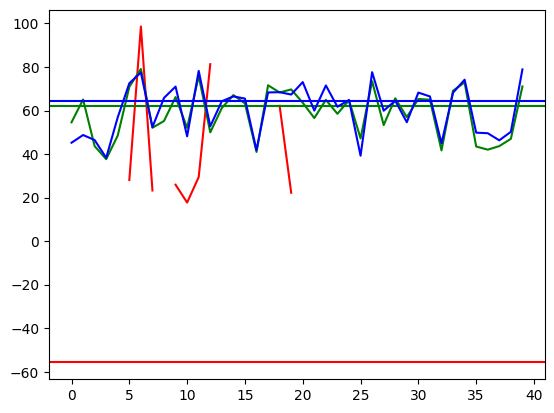

In [76]:
#robustL2M improvements
#get the data for the original file
orig_path =  'original.mp4'
#use the model to create a target median + 40 data
dict_orig = create_chart_data(orig_path)

#get the data for the robustls2
robu_path = 'robustl2s.mp4'
dict_robu = create_chart_data(robu_path)


pitch_model = VideoConvNet()
pitch_model.load_state_dict(torch.load(ENV_FOLDER_DATA_PROC + 'charts\\' + 'intensityVidNetV2.pt'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pitch_model.to(device=device)
import torch
torch.manual_seed(20) #20
pitch_model_predictions = pitch_model(dict_orig['v'].to(device).to(torch.float).movedim(0,1).unsqueeze(0) / 255.0)


#chart data
import numpy as np
prediction_line_val = (pitch_model_predictions.to('cpu').detach() * 100)[0][0].item()
prediction_data_pts = np.array((pitch_model_predictions.to('cpu').detach() * 100)[0][1:].tolist())
prediction_data_pts[prediction_data_pts > 100] = np.NaN
prediction_data_pts[prediction_data_pts < 10] = np.NaN
#zero out anything under 80 hz and over 280 hz
print(prediction_line_val)
#print(prediction_data_pts)

original_line_val = np.nanmedian(list(filter(None, dict_orig['i']) ))
original_data_pts = np.array(dict_orig['i'])
original_data_pts[original_data_pts > 100] = np.NaN
original_data_pts[original_data_pts < 10] = np.NaN
print(original_line_val)
#print(original_data_pts)

robu_line_val = np.nanmedian(list(filter(None, dict_robu['i']) ))
robu_data_pts = np.array(dict_robu['i'])
robu_data_pts[robu_data_pts > 100] = np.NaN
robu_data_pts[robu_data_pts < 10] = np.NaN
print(robu_line_val)
#print(robu_data_pts)


import matplotlib.pyplot as plt
plt.axhline(y=prediction_line_val, color='r', linestyle='-')
plt.plot(list(range(40)), prediction_data_pts, color = 'r')
plt.axhline(y=original_line_val, color='g', linestyle='-')
plt.plot(list(range(40)), original_data_pts, color = 'g')
plt.axhline(y=robu_line_val, color='b', linestyle='-')
plt.plot(list(range(40)), robu_data_pts, color = 'b')
plt.show()

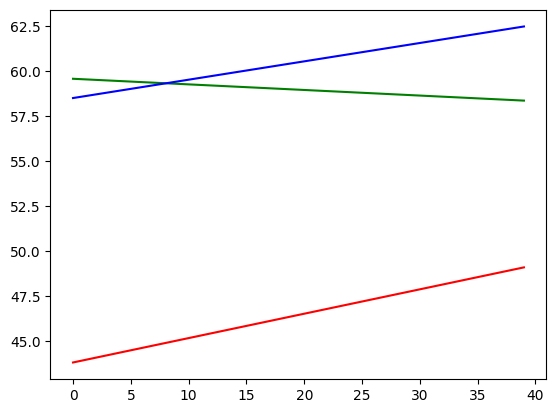

In [77]:
#this looks bad
import matplotlib.pyplot as plt
idx = np.isfinite(prediction_data_pts)
pred_m, pred_b = np.polyfit(np.array(list(range(40)))[idx], prediction_data_pts[idx], 1)
plt.plot(list(range(40)), pred_m*np.array(list(range(40))) + pred_b, color = 'r')

idx = np.isfinite(original_data_pts)
orig_m, orig_b = np.polyfit(np.array(list(range(40)))[idx], original_data_pts[idx], 1)
plt.plot(list(range(40)), orig_m*np.array(list(range(40))) + orig_b, color = 'g')

idx = np.isfinite(robu_data_pts)
robu_m, robu_b = np.polyfit(np.array(list(range(40)))[idx], robu_data_pts[idx], 1)
plt.plot(list(range(40)), robu_m*np.array(list(range(40))) + robu_b, color = 'b')
plt.show()

<H1> Shimmer </H1>

MoviePy - Writing audio in E:\W4732 Computer Vision\Final Paper Data Proc\charts\temp.mp3


MoviePy - Done.


Moviepy - Building video E:\W4732 Computer Vision\Final Paper Data Proc\charts\temp.mp4.
Moviepy - Writing video E:\W4732 Computer Vision\Final Paper Data Proc\charts\temp.mp4



Moviepy - Done !
Moviepy - video ready E:\W4732 Computer Vision\Final Paper Data Proc\charts\temp.mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
MoviePy - Writing audio in E:\W4732 Computer Vision\Final Paper Data Proc\charts\temp.mp3


MoviePy - Done.


Moviepy - Building video E:\W4732 Computer Vision\Final Paper Data Proc\charts\temp.mp4.
Moviepy - Writing video E:\W4732 Computer Vision\Final Paper Data Proc\charts\temp.mp4



Moviepy - Done !
Moviepy - video ready E:\W4732 Computer Vision\Final Paper Data Proc\charts\temp.mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
-0.24594981968402863
0.12007337852001956
0.1370903561451177


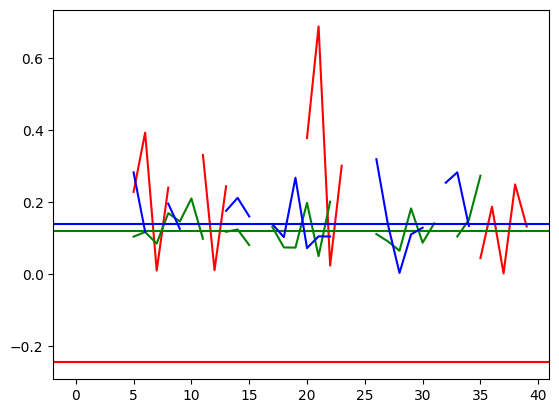

In [90]:
#robustL2M improvements
#get the data for the original file
orig_path =  'original.mp4'
#use the model to create a target median + 40 data
dict_orig = create_chart_data(orig_path)

#get the data for the robustls2
robu_path = 'robustl2s.mp4'
dict_robu = create_chart_data(robu_path)


pitch_model = VideoConvNet()
pitch_model.load_state_dict(torch.load(ENV_FOLDER_DATA_PROC + 'charts\\' + 'shimmerVidNetV2.pt'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pitch_model.to(device=device)
import torch
torch.manual_seed(20) #20
pitch_model_predictions = pitch_model(dict_orig['v'].to(device).to(torch.float).movedim(0,1).unsqueeze(0) / 255.0)


#chart data
import numpy as np
prediction_line_val = (pitch_model_predictions.to('cpu').detach() * 2)[0][0].item()
prediction_data_pts = np.array((pitch_model_predictions.to('cpu').detach() * 2)[0][1:].tolist())
prediction_data_pts[prediction_data_pts > 2] = np.NaN
prediction_data_pts[prediction_data_pts < 0] = np.NaN
#zero out anything under 80 hz and over 280 hz
print(prediction_line_val)
#print(prediction_data_pts)

original_line_val = np.nanmedian(list(filter(None, dict_orig['s']) ))
original_data_pts = np.array(dict_orig['s'])
original_data_pts[original_data_pts > 2] = np.NaN
original_data_pts[original_data_pts < 0] = np.NaN
print(original_line_val)
#print(original_data_pts)

robu_line_val = np.nanmedian(list(filter(None, dict_robu['s']) ))
robu_data_pts = np.array(dict_robu['s'])
robu_data_pts[robu_data_pts > 2] = np.NaN
robu_data_pts[robu_data_pts < 0] = np.NaN
print(robu_line_val)
#print(robu_data_pts)


import matplotlib.pyplot as plt
plt.axhline(y=prediction_line_val, color='r', linestyle='-')
plt.plot(list(range(40)), prediction_data_pts, color = 'r')
plt.axhline(y=original_line_val, color='g', linestyle='-')
plt.plot(list(range(40)), original_data_pts, color = 'g')
plt.axhline(y=robu_line_val, color='b', linestyle='-')
plt.plot(list(range(40)), robu_data_pts, color = 'b')
plt.show()

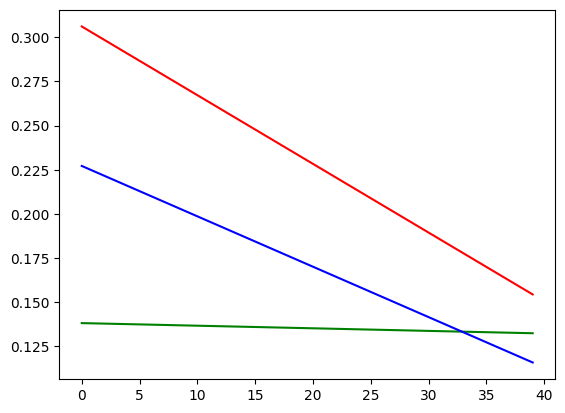

In [92]:
#this is worse
import matplotlib.pyplot as plt
idx = np.isfinite(prediction_data_pts)
pred_m, pred_b = np.polyfit(np.array(list(range(40)))[idx], prediction_data_pts[idx], 1)
plt.plot(list(range(40)), pred_m*np.array(list(range(40))) + pred_b, color = 'r')

idx = np.isfinite(original_data_pts)
orig_m, orig_b = np.polyfit(np.array(list(range(40)))[idx], original_data_pts[idx], 1)
plt.plot(list(range(40)), orig_m*np.array(list(range(40))) + orig_b, color = 'g')

idx = np.isfinite(robu_data_pts)
robu_m, robu_b = np.polyfit(np.array(list(range(40)))[idx], robu_data_pts[idx], 1)
plt.plot(list(range(40)), robu_m*np.array(list(range(40))) + robu_b, color = 'b')
plt.show()

<H1> Jitter </H1>

MoviePy - Writing audio in E:\W4732 Computer Vision\Final Paper Data Proc\charts\temp.mp3


MoviePy - Done.


Moviepy - Building video E:\W4732 Computer Vision\Final Paper Data Proc\charts\temp.mp4.
Moviepy - Writing video E:\W4732 Computer Vision\Final Paper Data Proc\charts\temp.mp4



Moviepy - Done !
Moviepy - video ready E:\W4732 Computer Vision\Final Paper Data Proc\charts\temp.mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
MoviePy - Writing audio in E:\W4732 Computer Vision\Final Paper Data Proc\charts\temp.mp3


MoviePy - Done.


Moviepy - Building video E:\W4732 Computer Vision\Final Paper Data Proc\charts\temp.mp4.
Moviepy - Writing video E:\W4732 Computer Vision\Final Paper Data Proc\charts\temp.mp4



Moviepy - Done !
Moviepy - video ready E:\W4732 Computer Vision\Final Paper Data Proc\charts\temp.mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
0.06899840384721756
0.02486820380824564
0.029944297530351265


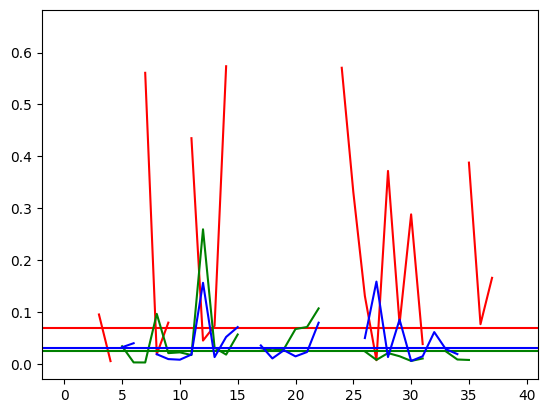

In [93]:
#robustL2M improvements
#get the data for the original file
orig_path =  'original.mp4'
#use the model to create a target median + 40 data
dict_orig = create_chart_data(orig_path)

#get the data for the robustls2
robu_path = 'robustl2s.mp4'
dict_robu = create_chart_data(robu_path)


pitch_model = VideoConvNet()
pitch_model.load_state_dict(torch.load(ENV_FOLDER_DATA_PROC + 'charts\\' + 'jitterVidNetV2.pt'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pitch_model.to(device=device)
import torch
torch.manual_seed(20) #20
pitch_model_predictions = pitch_model(dict_orig['v'].to(device).to(torch.float).movedim(0,1).unsqueeze(0) / 255.0)

#chart data
import numpy as np
prediction_line_val = (pitch_model_predictions.to('cpu').detach())[0][0].item()
prediction_data_pts = np.array((pitch_model_predictions.to('cpu').detach() )[0][1:].tolist())
prediction_data_pts[prediction_data_pts > 1] = np.NaN
prediction_data_pts[prediction_data_pts < 0] = np.NaN
#zero out anything under 80 hz and over 280 hz
print(prediction_line_val)
#print(prediction_data_pts)

original_line_val = np.nanmedian(list(filter(None, dict_orig['j']) ))
original_data_pts = np.array(dict_orig['j'])
original_data_pts[original_data_pts > 1] = np.NaN
original_data_pts[original_data_pts < 0] = np.NaN
print(original_line_val)
#print(original_data_pts)

robu_line_val = np.nanmedian(list(filter(None, dict_robu['j']) ))
robu_data_pts = np.array(dict_robu['j'])
robu_data_pts[robu_data_pts > 1] = np.NaN
robu_data_pts[robu_data_pts < 0] = np.NaN
print(robu_line_val)
#print(robu_data_pts)


import matplotlib.pyplot as plt
plt.axhline(y=prediction_line_val, color='r', linestyle='-')
plt.plot(list(range(40)), prediction_data_pts, color = 'r')
plt.axhline(y=original_line_val, color='g', linestyle='-')
plt.plot(list(range(40)), original_data_pts, color = 'g')
plt.axhline(y=robu_line_val, color='b', linestyle='-')
plt.plot(list(range(40)), robu_data_pts, color = 'b')
plt.show()

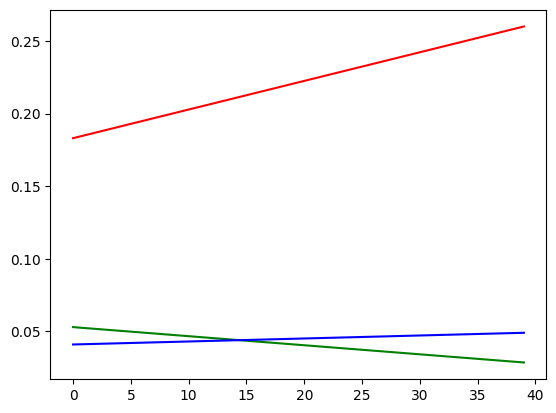

In [94]:
#really bad - this one doesn't even predict valid values
import matplotlib.pyplot as plt
idx = np.isfinite(prediction_data_pts)
pred_m, pred_b = np.polyfit(np.array(list(range(40)))[idx], prediction_data_pts[idx], 1)
plt.plot(list(range(40)), pred_m*np.array(list(range(40))) + pred_b, color = 'r')

idx = np.isfinite(original_data_pts)
orig_m, orig_b = np.polyfit(np.array(list(range(40)))[idx], original_data_pts[idx], 1)
plt.plot(list(range(40)), orig_m*np.array(list(range(40))) + orig_b, color = 'g')

idx = np.isfinite(robu_data_pts)
robu_m, robu_b = np.polyfit(np.array(list(range(40)))[idx], robu_data_pts[idx], 1)
plt.plot(list(range(40)), robu_m*np.array(list(range(40))) + robu_b, color = 'b')
plt.show()

<H1> Harmonics </H1>

MoviePy - Writing audio in E:\W4732 Computer Vision\Final Paper Data Proc\charts\temp.mp3


MoviePy - Done.


Moviepy - Building video E:\W4732 Computer Vision\Final Paper Data Proc\charts\temp.mp4.
Moviepy - Writing video E:\W4732 Computer Vision\Final Paper Data Proc\charts\temp.mp4



Moviepy - Done !
Moviepy - video ready E:\W4732 Computer Vision\Final Paper Data Proc\charts\temp.mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
MoviePy - Writing audio in E:\W4732 Computer Vision\Final Paper Data Proc\charts\temp.mp3


MoviePy - Done.


Moviepy - Building video E:\W4732 Computer Vision\Final Paper Data Proc\charts\temp.mp4.
Moviepy - Writing video E:\W4732 Computer Vision\Final Paper Data Proc\charts\temp.mp4



Moviepy - Done !
Moviepy - video ready E:\W4732 Computer Vision\Final Paper Data Proc\charts\temp.mp4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
-19.29783821105957
5.230417969030595
4.416068818080135


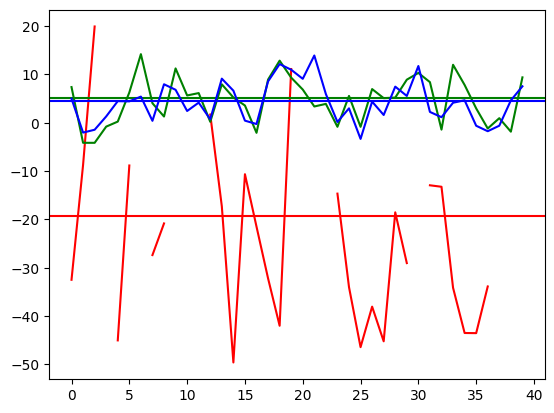

In [95]:
#robustL2M improvements
#get the data for the original file
orig_path =  'original.mp4'
#use the model to create a target median + 40 data
dict_orig = create_chart_data(orig_path)

#get the data for the robustls2
robu_path = 'robustl2s.mp4'
dict_robu = create_chart_data(robu_path)


pitch_model = VideoConvNet()
pitch_model.load_state_dict(torch.load(ENV_FOLDER_DATA_PROC + 'charts\\' + 'harmonicsVidNetV2.pt'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pitch_model.to(device=device)
import torch
torch.manual_seed(60) #20
pitch_model_predictions = pitch_model(dict_orig['v'].to(device).to(torch.float).movedim(0,1).unsqueeze(0) / 255.0)


#chart data
import numpy as np
prediction_line_val = (pitch_model_predictions.to('cpu').detach() * 100 - 40)[0][0].item()
prediction_data_pts = np.array((pitch_model_predictions.to('cpu').detach() * 100 - 40)[0][1:].tolist())
prediction_data_pts[prediction_data_pts > 70] = np.NaN
prediction_data_pts[prediction_data_pts < -50] = np.NaN
#zero out anything under 80 hz and over 280 hz
print(prediction_line_val)
#print(prediction_data_pts)

original_line_val = np.nanmedian(list(filter(None, dict_orig['h']) ))
original_data_pts = np.array(dict_orig['h'])
original_data_pts[original_data_pts > 70] = np.NaN
original_data_pts[original_data_pts < -50] = np.NaN
print(original_line_val)
#print(original_data_pts)

robu_line_val = np.nanmedian(list(filter(None, dict_robu['h']) ))
robu_data_pts = np.array(dict_robu['h'])
robu_data_pts[robu_data_pts > 70] = np.NaN
robu_data_pts[robu_data_pts < -50] = np.NaN
print(robu_line_val)
#print(robu_data_pts)


import matplotlib.pyplot as plt
plt.axhline(y=prediction_line_val, color='r', linestyle='-')
plt.plot(list(range(40)), prediction_data_pts, color = 'r')
plt.axhline(y=original_line_val, color='g', linestyle='-')
plt.plot(list(range(40)), original_data_pts, color = 'g')
plt.axhline(y=robu_line_val, color='b', linestyle='-')
plt.plot(list(range(40)), robu_data_pts, color = 'b')
plt.show()

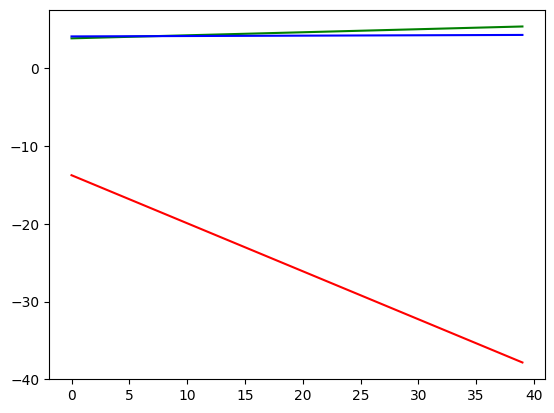

In [97]:
#this is pretty bad
import matplotlib.pyplot as plt
idx = np.isfinite(prediction_data_pts)
pred_m, pred_b = np.polyfit(np.array(list(range(40)))[idx], prediction_data_pts[idx], 1)
plt.plot(list(range(40)), pred_m*np.array(list(range(40))) + pred_b, color = 'r')

idx = np.isfinite(original_data_pts)
orig_m, orig_b = np.polyfit(np.array(list(range(40)))[idx], original_data_pts[idx], 1)
plt.plot(list(range(40)), orig_m*np.array(list(range(40))) + orig_b, color = 'g')

idx = np.isfinite(robu_data_pts)
robu_m, robu_b = np.polyfit(np.array(list(range(40)))[idx], robu_data_pts[idx], 1)
plt.plot(list(range(40)), robu_m*np.array(list(range(40))) + robu_b, color = 'b')
plt.show()

<H1> Analysis </H1>

In [42]:
## Model Training 1 ##
import pandas as pd
import json
import copy
import csv
import pickle
import torchvision
import itertools
import torch
import glob
import random
import numpy as np



#get number after # but before space afterwards
folderpath_sourcedf = ENV_FOLDER_DATA_PROC + 'sourcedf\\'
folderpath_targetdf = ENV_FOLDER_DATA_PROC + 'targetdf\\'

## get overlap between sourcedf files and targetdf files

#note - source is actually a dict of dict of tensors
dict_sourcedf = {}
list_sourcedf_eps = []
for path_pickle in glob.glob(folderpath_sourcedf + '*.pickle'):
    dict_temp = {}
    dict_temp['path'] = path_pickle
    str_basenm = os.path.basename(path_pickle)
    dict_temp['basenm'] = str_basenm
    dict_temp['str_epnum'] = str_basenm.split('.')[0]
    int_epnum = int(dict_temp['str_epnum'])
    dict_temp['int_epnum'] = int_epnum
    list_sourcedf_eps.append(int_epnum)
    dict_sourcedf[int_epnum] = dict_temp

#note - target is actually a df
dict_targetdf = {}
list_targetdf_eps = []
for path_pickle in glob.glob(folderpath_targetdf + '*.pickle'):
    dict_temp = {}
    dict_temp['path'] = path_pickle
    str_basenm = os.path.basename(path_pickle)
    dict_temp['basenm'] = str_basenm
    dict_temp['str_epnum'] = str_basenm.split('.')[0]
    int_epnum = int(dict_temp['str_epnum'])
    dict_temp['int_epnum'] = int_epnum
    list_targetdf_eps.append(int_epnum)
    dict_targetdf[int_epnum] = dict_temp

#populate matches
list_eps = []
for src_ep in list_sourcedf_eps:
    if src_ep in list_targetdf_eps:
        list_eps.append(src_ep)

#40 data elements
list_datacols = []
#list_datacols.append('m')
for i in range(40):
    list_datacols.append('d' + str(i))

#define model pieces
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#pitch_model = VideoConvNet()
#pitch_model.load_state_dict(torch.load(ENV_FOLDER_DATA_PROC + 'charts\\' + 'pitchVidNetV4.pt'))
pitch_model = JWVideoConvNet()
pitch_model.load_state_dict(torch.load(ENV_FOLDER_DATA_PROC + 'charts\\' + 'JWPitchModv03.pt'))
pitch_model.to(device=device)
cor_pitch_true = []
cor_pitch_pred = []
cor_pitch_m_true = []
cor_pitch_m_pred = []

block_comment = """ intensity_model = VideoConvNet()
intensity_model.load_state_dict(torch.load(ENV_FOLDER_DATA_PROC + 'charts\\' + 'intensityVidNetV2.pt'))
intensity_model.to(device=device)
cor_intensity_true = []
cor_intensity_pred = []
cor_intensity_m_true = []
cor_intensity_m_pred = []

shimmer_model = VideoConvNet()
shimmer_model.load_state_dict(torch.load(ENV_FOLDER_DATA_PROC + 'charts\\' + 'shimmerVidNetV2.pt'))
shimmer_model.to(device=device)
cor_shimmer_true = []
cor_shimmer_pred = []
cor_shimmer_m_true = []
cor_shimmer_m_pred = []

jitter_model = VideoConvNet()
jitter_model.load_state_dict(torch.load(ENV_FOLDER_DATA_PROC + 'charts\\' + 'jitterVidNetV2.pt'))
jitter_model.to(device=device)
cor_jitter_true = []
cor_jitter_pred = []
cor_jitter_m_true = []
cor_jitter_m_pred = []

harmonics_model = VideoConvNet()
harmonics_model.load_state_dict(torch.load(ENV_FOLDER_DATA_PROC + 'charts\\' + 'harmonicsVidNetV2.pt'))
harmonics_model.to(device=device)
cor_harmonics_true = []
cor_harmonics_pred = []
cor_harmonics_m_true = []
cor_harmonics_m_pred = [] """

transform = torchvision.transforms.Normalize( mean=(255*0.5), std=(255*0.5) )

for int_eps in list_eps:
    
    dict_target = {}
    with open(dict_targetdf[int_eps]['path'], 'rb') as file:
        dict_target =  pickle.load(file)
                
    #load video frames into memory
    dict_source = {}
    with open(dict_sourcedf[int_eps]['path'], 'rb') as file:
        dict_source = pickle.load(file)

    

    #loop for data elements
    for key_int,val_frames in dict_source.items():
        int_epnum = int_eps
        int_segnum = key_int
        print('Ep:' + str(int_epnum) + ' Seg:' + str(int_segnum))
        #feed values into the predict / loss / optimize cycle
        #if int_segnum not in dict_target.keys():
        #    continue
        inputs = None
        labels = None

        inputs = dict_source[int_segnum]
        #pad inputs
        for x in range(40 - len(inputs)):
            inputs.append( torch.empty((1,360,640), dtype=torch.int8) )
        inputs = torch.stack(inputs[:40], 0)
        inputs_trans = copy.deepcopy(inputs)
        #transform inputs
        
        inputs = inputs.to(device).to(torch.float).movedim(0,1).unsqueeze(0)
        print(inputs)
        
        #Pitch
        
        label_df = dict_target.query('seg==' + str(int_segnum) + ' & type=="p"' )
        #print(label_df)
        labels_data_pts = np.array(label_df[list_datacols].values).squeeze()
        if len(labels_data_pts) < 0:
            print('No labels for Ep:' + str(int_epnum) + ' Seg:' + str(int_segnum))
            continue
        #print(labels_data_pts)
        idx = np.isfinite(labels_data_pts)
        x = np.array(list(range(40)))[idx]
        y = labels_data_pts[idx]
        pred_mt, pred_bt = np.polyfit(x,y , 1)

        torch.manual_seed(60)
        #with torch.no_grad():
        #need to be transformed for JW model
        #not for Jacob's
        model_predictions = pitch_model(inputs)
        #print(inputs)
        #print(model_predictions)
        print(model_predictions)
        prediction_data_pts = np.array((model_predictions.to('cpu').detach())[0][1:].tolist()) * 600
        prediction_data_pts[prediction_data_pts > 280] = np.NaN
        prediction_data_pts[prediction_data_pts < 60] = np.NaN
        #print(prediction_data_pts)
        idx = np.isfinite(prediction_data_pts)
        pred_mp, pred_bp = np.polyfit(np.array(list(range(40)))[idx], prediction_data_pts[idx], 1)
        print(pred_mp)

        cor_pitch_true.append(pred_mt)
        cor_pitch_pred.append(pred_mp)
        cor_pitch_m_true.append(label_df['m'])
        cor_pitch_m_pred.append((model_predictions.to('cpu').detach())[0][0])
        print((model_predictions.to('cpu').detach())[0][0])

        try:
            block_comment = """ #Intensity

            label_df = dict_target.query('seg==' + str(int_segnum) + ' & type=="i"' )
            labels_data_pts = np.array(label_df[list_datacols].values).squeeze()
            idx = np.isfinite(labels_data_pts)
            pred_mt, pred_bt = np.polyfit(np.array(list(range(40)))[idx], labels_data_pts[idx], 1)

            torch.manual_seed(60)
            with torch.no_grad():
                model_predictions = intensity_model(inputs)
            prediction_data_pts = np.array((model_predictions.to('cpu').detach())[0][1:].tolist()) * 100
            prediction_data_pts[prediction_data_pts > 100] = np.NaN
            prediction_data_pts[prediction_data_pts < 10] = np.NaN  
            idx = np.isfinite(prediction_data_pts)
            pred_mp, pred_bp = np.polyfit(np.array(list(range(40)))[idx], prediction_data_pts[idx], 1)

            cor_intensity_true.append(pred_mt)
            cor_intensity_pred.append(pred_mp)
            cor_intensity_m_true.append(label_df['m'])
            cor_intensity_m_pred.append((model_predictions.to('cpu').detach())[0][0])
            #except:
            #    print('Intensity error for ep:' + str(int_epnum))

            #Jitter
            label_df = dict_target.query('seg==' + str(int_segnum) + ' & type=="j"' )
            labels_data_pts = np.array(label_df[list_datacols].values).squeeze()
            idx = np.isfinite(labels_data_pts)
            x = np.array(list(range(40)))[idx]
            y = labels_data_pts[idx]
            pred_mt, pred_bt = np.polyfit(x,y , 1)

            torch.manual_seed(60)
            with torch.no_grad():
                model_predictions = pitch_model(inputs)
            prediction_data_pts = np.array((model_predictions.to('cpu').detach())[0][1:].tolist())
            prediction_data_pts[prediction_data_pts > 1] = np.NaN
            prediction_data_pts[prediction_data_pts < 0] = np.NaN
            idx = np.isfinite(prediction_data_pts)
            pred_mp, pred_bp = np.polyfit(np.array(list(range(40)))[idx], prediction_data_pts[idx], 1)

            cor_jitter_true.append(pred_mt)
            cor_jitter_pred.append(pred_mp)
            cor_jitter_m_true.append(label_df['m'])
            cor_jitter_m_pred.append((model_predictions.to('cpu').detach())[0][0])
            
            #Shimmer
            label_df = dict_target.query('seg==' + str(int_segnum) + ' & type=="s"' )
            labels_data_pts = np.array(label_df[list_datacols].values).squeeze()
            idx = np.isfinite(labels_data_pts)
            pred_mt, pred_bt = np.polyfit(np.array(list(range(40)))[idx], labels_data_pts[idx], 1)

            torch.manual_seed(60)
            with torch.no_grad():
                model_predictions = pitch_model(inputs)
            prediction_data_pts = np.array((model_predictions.to('cpu').detach())[0][1:].tolist()) * 2
            prediction_data_pts[prediction_data_pts > 2] = np.NaN
            prediction_data_pts[prediction_data_pts < 0] = np.NaN
            idx = np.isfinite(prediction_data_pts)
            pred_mp, pred_bp = np.polyfit(np.array(list(range(40)))[idx], prediction_data_pts[idx], 1)

            cor_shimmer_true.append(pred_mt)
            cor_shimmer_pred.append(pred_mp)
            cor_shimmer_m_true.append(label_df['m'])
            cor_shimmer_m_pred.append((model_predictions.to('cpu').detach())[0][0])

            #Harmonics
            label_df = dict_target.query('seg==' + str(int_segnum) + ' & type=="h"' )
            labels_data_pts = np.array(label_df[list_datacols].values).squeeze()
            idx = np.isfinite(labels_data_pts)
            pred_mt, pred_bt = np.polyfit(np.array(list(range(40)))[idx], labels_data_pts[idx], 1)

            torch.manual_seed(60)
            with torch.no_grad():
                model_predictions = pitch_model(inputs)
            prediction_data_pts = np.array((model_predictions.to('cpu').detach())[0][1:].tolist()) * 100 - 40
            prediction_data_pts[prediction_data_pts > 70] = np.NaN
            prediction_data_pts[prediction_data_pts < -50] = np.NaN
            idx = np.isfinite(prediction_data_pts)
            pred_mp, pred_bp = np.polyfit(np.array(list(range(40)))[idx], prediction_data_pts[idx], 1)

            cor_harmonics_true.append(pred_mt)
            cor_harmonics_pred.append(pred_mp)
            cor_harmonics_m_true.append(label_df['m'])
            cor_harmonics_m_pred.append((model_predictions.to('cpu').detach())[0][0]) 
            """
        except:
            print('Failure for Ep:' + str(int_epnum) + ' Seg:' + str(int_segnum))
        
        

        



Ep:550 Seg:22
tensor([[[[[   0.,    0.,    0.,  ...,    0.,    0.,    0.],
           [   0.,    0.,    0.,  ...,    0.,    0.,    0.],
           [   0.,    0.,    0.,  ...,    0.,    0.,    0.],
           ...,
           [  17.,   17.,   17.,  ...,    0.,    0.,    0.],
           [  12.,   12.,   12.,  ...,    0.,    0.,    0.],
           [  11.,   11.,   11.,  ...,    0.,    0.,    0.]],

          [[   0.,    0.,    0.,  ...,    0.,    0.,    0.],
           [   0.,    0.,    0.,  ...,    0.,    0.,    0.],
           [   0.,    0.,    0.,  ...,    0.,    0.,    0.],
           ...,
           [  17.,   17.,   17.,  ...,    0.,    0.,    0.],
           [  12.,   12.,   12.,  ...,    0.,    0.,    0.],
           [  11.,   11.,   11.,  ...,    0.,    0.,    0.]],

          [[   0.,    0.,    0.,  ...,    0.,    0.,    0.],
           [   0.,    0.,    0.,  ...,    0.,    0.,    0.],
           [   0.,    0.,    0.,  ...,    0.,    0.,    0.],
           ...,
           [  17., 

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [15]:
#
from scipy.stats.stats import pearsonr    
print(pearsonr(cor_pitch_true,cor_pitch_pred))
print(pearsonr(np.array(cor_pitch_m_true).squeeze(),np.array(cor_pitch_m_pred).squeeze()))

print(pearsonr(cor_intensity_true,cor_intensity_pred))
print(pearsonr(np.array(cor_intensity_m_true).squeeze(),np.array(cor_intensity_m_pred).squeeze()))

print(pearsonr(cor_jitter_true,cor_jitter_pred))
print(pearsonr(np.array(cor_jitter_m_true).squeeze(),np.array(cor_jitter_m_pred).squeeze()))

print(pearsonr(cor_shimmer_true,cor_shimmer_pred))
print(pearsonr(np.array(cor_shimmer_m_true).squeeze(),np.array(cor_shimmer_m_pred).squeeze()))

print(pearsonr(cor_harmonics_true,cor_harmonics_pred))
print(pearsonr(np.array(cor_harmonics_m_true).squeeze(),np.array(cor_harmonics_m_pred).squeeze()))


(nan, nan)
(nan, nan)
(0.08781467688229928, 1.0317558900148025e-22)
(-0.0158888108123059, 0.07648639726287887)
(nan, nan)
(nan, nan)
(nan, nan)
(nan, nan)
(nan, nan)
(nan, nan)


In [17]:
cor_pitch_m_pred

[tensor(0.2570),
 tensor(0.2570),
 tensor(0.2570),
 tensor(0.2570),
 tensor(0.2570),
 tensor(0.2570),
 tensor(0.2570),
 tensor(0.2570),
 tensor(0.2570),
 tensor(0.2570),
 tensor(0.2570),
 tensor(0.2570),
 tensor(0.2570),
 tensor(0.2570),
 tensor(0.2570),
 tensor(0.2570),
 tensor(0.2570),
 tensor(0.2570),
 tensor(0.2570),
 tensor(0.2570),
 tensor(0.2570),
 tensor(0.2570),
 tensor(0.2570),
 tensor(0.2570),
 tensor(0.2570),
 tensor(0.2570),
 tensor(0.2570),
 tensor(0.2570),
 tensor(0.2570),
 tensor(0.2570),
 tensor(0.2570),
 tensor(0.2570),
 tensor(0.2570),
 tensor(0.2570),
 tensor(0.2570),
 tensor(0.2570),
 tensor(0.2570),
 tensor(0.2570),
 tensor(0.2570),
 tensor(0.2570),
 tensor(0.2570),
 tensor(0.2570),
 tensor(0.2570),
 tensor(0.2570),
 tensor(0.2570),
 tensor(0.2570),
 tensor(0.2570),
 tensor(0.2570),
 tensor(0.2570),
 tensor(0.2570),
 tensor(0.2570),
 tensor(0.2570),
 tensor(0.2570),
 tensor(0.2570),
 tensor(0.2570),
 tensor(0.2570),
 tensor(0.2570),
 tensor(0.2570),
 tensor(0.2570

In [8]:
print(cor_pitch_true)

[]


<H1> Debugging </H1>

In [21]:
#debugging

## Model Training 1 ##
import pandas as pd

import pickle
import torchvision
import torch
import glob
import numpy as np



#get number after # but before space afterwards
folderpath_sourcedf = ENV_FOLDER_DATA_PROC + 'sourcedf\\'
folderpath_targetdf = ENV_FOLDER_DATA_PROC + 'targetdf\\'

## get overlap between sourcedf files and targetdf files

#note - source is actually a dict of dict of tensors
dict_sourcedf = {}
list_sourcedf_eps = []
for path_pickle in glob.glob(folderpath_sourcedf + '*.pickle'):
    dict_temp = {}
    dict_temp['path'] = path_pickle
    str_basenm = os.path.basename(path_pickle)
    dict_temp['basenm'] = str_basenm
    dict_temp['str_epnum'] = str_basenm.split('.')[0]
    int_epnum = int(dict_temp['str_epnum'])
    dict_temp['int_epnum'] = int_epnum
    list_sourcedf_eps.append(int_epnum)
    dict_sourcedf[int_epnum] = dict_temp

#note - target is actually a df
dict_targetdf = {}
list_targetdf_eps = []
for path_pickle in glob.glob(folderpath_targetdf + '*.pickle'):
    dict_temp = {}
    dict_temp['path'] = path_pickle
    str_basenm = os.path.basename(path_pickle)
    dict_temp['basenm'] = str_basenm
    dict_temp['str_epnum'] = str_basenm.split('.')[0]
    int_epnum = int(dict_temp['str_epnum'])
    dict_temp['int_epnum'] = int_epnum
    list_targetdf_eps.append(int_epnum)
    dict_targetdf[int_epnum] = dict_temp

#populate matches
list_eps = []
for src_ep in list_sourcedf_eps:
    if src_ep in list_targetdf_eps:
        list_eps.append(src_ep)

#40 data elements
list_datacols = []
#list_datacols.append('m')
for i in range(40):
    list_datacols.append('d' + str(i))

#define model pieces
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#pitch_model = VideoConvNet()
#pitch_model.load_state_dict(torch.load(ENV_FOLDER_DATA_PROC + 'charts\\' + 'pitchVidNetV4.pt'))
pitch_model = JWVideoConvNet()
pitch_model.load_state_dict(torch.load(ENV_FOLDER_DATA_PROC + 'charts\\' + 'JWPitchModv01.pt'))
pitch_model.to(device=device)

transform = torchvision.transforms.Normalize( mean=(255*0.5), std=(255*0.5) )

for int_eps in list_eps:
    
    dict_target = {}
    with open(dict_targetdf[int_eps]['path'], 'rb') as file:
        dict_target =  pickle.load(file)
                
    #load video frames into memory
    dict_source = {}
    with open(dict_sourcedf[int_eps]['path'], 'rb') as file:
        dict_source = pickle.load(file)

    

    #loop for data elements
    for key_int,val_frames in dict_source.items():
        int_epnum = int_eps
        int_segnum = key_int
        print('Ep:' + str(int_epnum) + ' Seg:' + str(int_segnum))
        #feed values into the predict / loss / optimize cycle
        #if int_segnum not in dict_target.keys():
        #    continue
        inputs = None
        labels = None

        inputs = []
        #pad inputs
        for x in range(40 - len(inputs)):
            inputs.append( torch.empty((1,360,640), dtype=torch.int8) )
        inputs = torch.stack(inputs[:40], 0)
        inputs_trans = copy.deepcopy(inputs)
        #transform inputs
        
        inputs = inputs.to(device).to(torch.float).movedim(0,1).unsqueeze(0)
        inputs_trans = transform(inputs_trans.to(torch.float)).to(device).movedim(0,1).unsqueeze(0)

        #print(inputs)
        torch.manual_seed(60)
        with torch.no_grad():
            #need to be transformed for JW model
            #not for Jacob's
            model_predictions = pitch_model(inputs_trans)
            print(inputs)
            #print(model_predictions)
        print(model_predictions)
        prediction_data_pts = np.array((model_predictions.to('cpu').detach())[0][1:].tolist()) * 600
        prediction_data_pts[prediction_data_pts > 280] = np.NaN
        prediction_data_pts[prediction_data_pts < 60] = np.NaN
        #print(prediction_data_pts)
        idx = np.isfinite(prediction_data_pts)
        pred_mp, pred_bp = np.polyfit(np.array(list(range(40)))[idx], prediction_data_pts[idx], 1)
        print(pred_mp)


Ep:550 Seg:22
tensor([[[[[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
           [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
           [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
           ...,
           [17., 17., 17.,  ...,  0.,  0.,  0.],
           [12., 12., 12.,  ...,  0.,  0.,  0.],
           [11., 11., 11.,  ...,  0.,  0.,  0.]],

          [[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
           [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
           [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
           ...,
           [17., 17., 17.,  ...,  0.,  0.,  0.],
           [12., 12., 12.,  ...,  0.,  0.,  0.],
           [11., 11., 11.,  ...,  0.,  0.,  0.]],

          [[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
           [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
           [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
           ...,
           [17., 17., 17.,  ...,  0.,  0.,  0.],
           [16., 16., 16.,  ...,  0.,  0.,  0.],
           [16., 16., 16.,  ...,  0.,  0.,  0.]],

          ...,

          [[ 0.,  0.,  0.,  ...,  

KeyboardInterrupt: 